<a href="https://colab.research.google.com/github/teamgaon/lg_farm/blob/main/20220128_hj_plant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 사용 패키지

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import json
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/LG/plant/train.zip

Archive:  /content/drive/MyDrive/LG/plant/train.zip
   creating: train/
  inflating: train/00009_jpg.rf.b4187ecff7dbde2ac358f15e01adcecb.jpg  
  inflating: train/0000_jpg.rf.16c2413117fefd281d896f29db7789dc.jpg  
  inflating: train/0008003-strawberry-leaf-veiner-large_jpg.rf.d43d5d18783839215677d9155dce471f.jpg  
  inflating: train/000g_jpg.rf.849756b544aa925472b7e9fc46b1bd37.jpg  
  inflating: train/000gb_jpg.rf.0e1c9bf2f8db9b94464f7a1cae4bfcbc.jpg  
  inflating: train/003_JPG_jpg.rf.86fed674bd3d3151c7738a2ae370578e.jpg  
  inflating: train/004-10_jpg.rf.f3aa5b2d87dbcc260ec4895f954ae2c8.jpg  
  inflating: train/0042241_jpg.rf.bcaadbb721fdeb7e52d0638843eeda75.jpg  
  inflating: train/0052_jpg.rf.308bfadd743b49c9ba739e4f83d6c946.jpg  
  inflating: train/0061_jpg.rf.01edf4541c53b5b4015bef2add16f44e.jpg  
  inflating: train/007_JPG_jpg.rf.95eb0dcaf71de6b7d7c6255bf4c6d2ea.jpg  
  inflating: train/009-e1373768789869_jpg.rf.cb71a4a62bbc64926cdc557c5b26a024.jpg  
  inflating: train/00c_jpg.rf

In [4]:
!unzip /content/drive/MyDrive/LG/plant/test.zip

Archive:  /content/drive/MyDrive/LG/plant/test.zip
   creating: test/
  inflating: test/%2320+Bacterial+Spot+and+Speck_jpg.rf.56abfa1b8c07239d7a7b67f36649a105.jpg  
  inflating: test/0000_jpg.rf.7bf8d4c69ad253ee55c87d6e78d1ae28.jpg  
  inflating: test/000_jpg.rf.79b07e9657b862eca6972264b5e2fe0c.jpg  
  inflating: test/00_jpg.rf.7fa2b9652948e8c39a51a68ec5c6b70a.jpg  
  inflating: test/00pe_jpg.rf.42b93f15a0cec3a936d3a236bf71c5a8.jpg  
  inflating: test/01_jpg.rf.9c39f014290d5a331926f19f5c268200.jpg  
  inflating: test/02_-Rust-2017-207u24s_jpg.rf.cb22459400f68cb6d111d18db2f7d834.jpg  
  inflating: test/02c_jpg.rf.8ccc7cfab5597c03b0c2f83f7f0f1df3.jpg  
  inflating: test/039b47d574bc4bb8a14259a1cd96a741_jpg.rf.1f0673225f876af4143d937a5bee973c.jpg  
  inflating: test/03gb_jpg.rf.bd48ab850353cefcfed664c3041abda1.jpg  
  inflating: test/052609%20Hartman%20Crabapple%20scab%20single%20leaf_JPG_jpg.rf.28e5ae89118129c271d86a720d3f5985.jpg  
  inflating: test/0605_Rust-induced_leafspot_jpg.rf.a85

In [5]:
train_classes = pd.read_table('/content/drive/MyDrive/LG/plant/train_classes.txt',names=['filename', 'Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf','Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Soybean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf', 'grape leaf', 'grape leaf black rot'],sep=',')
test_classes = pd.read_table('/content/drive/MyDrive/LG/plant/test_classes.txt',names=['filename', 'Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf','Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Soybean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf', 'grape leaf', 'grape leaf black rot'],sep=',')

display(train_classes)
display(test_classes)

,filename,Apple Scab Leaf,Apple leaf,Apple rust leaf,Bell_pepper leaf,Bell_pepper leaf spot,Blueberry leaf,Cherry leaf,Corn Gray leaf spot,Corn leaf blight,Corn rust leaf,Peach leaf,Potato leaf,Potato leaf early blight,Potato leaf late blight,Raspberry leaf,Soyabean leaf,Soybean leaf,Squash Powdery mildew leaf,Strawberry leaf,Tomato Early blight leaf,Tomato Septoria leaf spot,Tomato leaf,Tomato leaf bacterial spot,Tomato leaf late blight,Tomato leaf mosaic virus,Tomato leaf yellow virus,Tomato mold leaf,Tomato two spotted spider mites leaf,grape leaf,grape leaf black rot
0,2017-08-27%2B-%2BLate%2BBlight%2Bon%2BGypsy%2B...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,Slide1_preview_jpg.rf.00f57cfc188631c10e10e2b9...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,d-to-tylv-fo005-14496A31BE70553130A_jpg.rf.017...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2-3%20Gray%20leaf%20spot%20BRUCE_jpg.rf.0040c2...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,blueberry-leaf-isolated-white-background-blueb...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,IMG_8502_JPG_jpg.rf.ff738ad1b405492cbc603a82dd...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2324,role-of-whitefly-in-plant-virus-transmission-b...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2325,grape2b_jpg.rf.ffbc48866d22fdde1f3d6337d73a15d...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2326,tomato-plant-leaves-brown-spots-tomato-leaves-...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


,filename,Apple Scab Leaf,Apple leaf,Apple rust leaf,Bell_pepper leaf,Bell_pepper leaf spot,Blueberry leaf,Cherry leaf,Corn Gray leaf spot,Corn leaf blight,Corn rust leaf,Peach leaf,Potato leaf,Potato leaf early blight,Potato leaf late blight,Raspberry leaf,Soyabean leaf,Soybean leaf,Squash Powdery mildew leaf,Strawberry leaf,Tomato Early blight leaf,Tomato Septoria leaf spot,Tomato leaf,Tomato leaf bacterial spot,Tomato leaf late blight,Tomato leaf mosaic virus,Tomato leaf yellow virus,Tomato mold leaf,Tomato two spotted spider mites leaf,grape leaf,grape leaf black rot
0,glyphosate_jpg.rf.01dea2d24a1e3591855a68e077bb...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,6134794031202304_jpeg_jpg.rf.021531229ad8d669e...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,squashsilver2_JPG_jpg.rf.02bdb1c8a5c8bdf6f689f...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,peach-leaf-16690421_jpg.rf.030bd0c31f731f86e54...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20180511_091133-24l1vhg-e1526047988236_jpg.rf....,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,toma_TMV_jpg.rf.fadfed6938fbeef46c39f78a02da3b...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
235,17fc47_jpg.rf.fe1c3b512f4182d08f00ac2c612ddb1c...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
236,7190f27ead55c0f6e3ff8b982972810a5446a9713a49d_...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
237,636368370164094909-late-blight-15-_jpg.rf.febe...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [38]:
def name_to_label(name:str):
  for col in train_classes.columns:
    if train_classes.loc[train_classes['filename'] == name, col].item() == 1:
      return col

In [40]:
train_classes['name'] = train_classes['filename'].map(name_to_label)

In [41]:
train_classes

,filename,Apple Scab Leaf,Apple leaf,Apple rust leaf,Bell_pepper leaf,Bell_pepper leaf spot,Blueberry leaf,Cherry leaf,Corn Gray leaf spot,Corn leaf blight,Corn rust leaf,Peach leaf,Potato leaf,Potato leaf early blight,Potato leaf late blight,Raspberry leaf,Soyabean leaf,Soybean leaf,Squash Powdery mildew leaf,Strawberry leaf,Tomato Early blight leaf,Tomato Septoria leaf spot,Tomato leaf,Tomato leaf bacterial spot,Tomato leaf late blight,Tomato leaf mosaic virus,Tomato leaf yellow virus,Tomato mold leaf,Tomato two spotted spider mites leaf,grape leaf,grape leaf black rot,name
0,2017-08-27%2B-%2BLate%2BBlight%2Bon%2BGypsy%2B...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Tomato leaf late blight
1,Slide1_preview_jpg.rf.00f57cfc188631c10e10e2b9...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Corn leaf blight
2,d-to-tylv-fo005-14496A31BE70553130A_jpg.rf.017...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Tomato mold leaf
3,2-3%20Gray%20leaf%20spot%20BRUCE_jpg.rf.0040c2...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Corn leaf blight
4,blueberry-leaf-isolated-white-background-blueb...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Blueberry leaf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,IMG_8502_JPG_jpg.rf.ff738ad1b405492cbc603a82dd...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Blueberry leaf
2324,role-of-whitefly-in-plant-virus-transmission-b...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Tomato leaf yellow virus
2325,grape2b_jpg.rf.ffbc48866d22fdde1f3d6337d73a15d...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,grape leaf
2326,tomato-plant-leaves-brown-spots-tomato-leaves-...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Tomato leaf bacterial spot


In [45]:
train_disease = train_classes[['filename','name']]
train_disease

,filename,name
0,2017-08-27%2B-%2BLate%2BBlight%2Bon%2BGypsy%2B...,Tomato leaf late blight
1,Slide1_preview_jpg.rf.00f57cfc188631c10e10e2b9...,Corn leaf blight
2,d-to-tylv-fo005-14496A31BE70553130A_jpg.rf.017...,Tomato mold leaf
3,2-3%20Gray%20leaf%20spot%20BRUCE_jpg.rf.0040c2...,Corn leaf blight
4,blueberry-leaf-isolated-white-background-blueb...,Blueberry leaf
...,...,...
2323,IMG_8502_JPG_jpg.rf.ff738ad1b405492cbc603a82dd...,Blueberry leaf
2324,role-of-whitefly-in-plant-virus-transmission-b...,Tomato leaf yellow virus
2325,grape2b_jpg.rf.ffbc48866d22fdde1f3d6337d73a15d...,grape leaf
2326,tomato-plant-leaves-brown-spots-tomato-leaves-...,Tomato leaf bacterial spot


In [46]:
def name_to_label(name:str):
  for col in test_classes.columns:
    if test_classes.loc[test_classes['filename'] == name, col].item() == 1:
      return col

test_classes['name'] = test_classes['filename'].map(name_to_label)

test_disease = test_classes[['filename','name']]
test_disease

,filename,name
0,glyphosate_jpg.rf.01dea2d24a1e3591855a68e077bb...,Tomato leaf yellow virus
1,6134794031202304_jpeg_jpg.rf.021531229ad8d669e...,Tomato Septoria leaf spot
2,squashsilver2_JPG_jpg.rf.02bdb1c8a5c8bdf6f689f...,None
3,peach-leaf-16690421_jpg.rf.030bd0c31f731f86e54...,Peach leaf
4,20180511_091133-24l1vhg-e1526047988236_jpg.rf....,None
...,...,...
234,toma_TMV_jpg.rf.fadfed6938fbeef46c39f78a02da3b...,Tomato leaf mosaic virus
235,17fc47_jpg.rf.fe1c3b512f4182d08f00ac2c612ddb1c...,Tomato leaf yellow virus
236,7190f27ead55c0f6e3ff8b982972810a5446a9713a49d_...,Peach leaf
237,636368370164094909-late-blight-15-_jpg.rf.febe...,Tomato leaf late blight


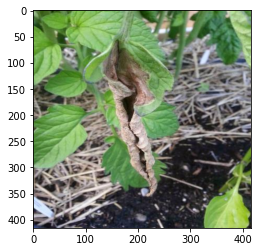

In [61]:
img_1 = cv2.imread("/content/train/"+train_disease['filename'][0])
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
plt.show()

In [62]:
train_disease['name'][0]

'Tomato leaf late blight'

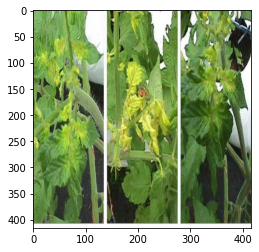

In [63]:
img_2 = cv2.imread("/content/test/"+test_disease['filename'][0])
plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
plt.show()

In [64]:
test_disease['name'][0]

'Tomato leaf yellow virus'